## Histogram of the image values

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import celestializer as cl
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
files = cl.list_observations()
df = cl.raw_to_df(files)

In [4]:
df_observation = df[df.filepath.str.startswith("observations")]
shutter_series = cl.grab_series(df_observation, "shutter")
n_shutter = len(shutter_series)
display(shutter_series)

print("Load images")
imgs = [
    (row["shutter"], cl.RawImage(cl.Paths.data / row["filepath"]).load())
    for _, row in tqdm(shutter_series.iterrows(), total=n_shutter)
]

,filepath,width,height,focal_length,aperture,shutter,iso,timestamp,camera,bit_depth
41,observations/2024-11-05/IMG_3347.CR2,5202,3465,23.0,3.5,0.1,6400,2024-11-05 00:57:16,Canon EOS 1200D,14
40,observations/2024-11-05/IMG_3346.CR2,5202,3465,23.0,3.5,0.4,6400,2024-11-05 00:57:06,Canon EOS 1200D,14
39,observations/2024-11-05/IMG_3345.CR2,5202,3465,23.0,3.5,1.0,6400,2024-11-05 00:56:46,Canon EOS 1200D,14
38,observations/2024-11-05/IMG_3344.CR2,5202,3465,23.0,3.5,2.5,6400,2024-11-05 00:56:32,Canon EOS 1200D,14
37,observations/2024-11-05/IMG_3343.CR2,5202,3465,23.0,3.5,4.0,6400,2024-11-05 00:56:21,Canon EOS 1200D,14
36,observations/2024-11-05/IMG_3342.CR2,5202,3465,23.0,3.5,5.0,6400,2024-11-05 00:56:05,Canon EOS 1200D,14
42,observations/2024-11-05/IMG_3348.CR2,5202,3465,23.0,3.5,10.0,6400,2024-11-05 00:57:44,Canon EOS 1200D,14
35,observations/2024-11-05/IMG_3341.CR2,5202,3465,23.0,3.5,30.0,6400,2024-11-05 00:55:06,Canon EOS 1200D,14


Load images


100%|██████████| 8/8 [00:18<00:00,  2.33s/it]


In [5]:
values = []

for shutter, img in tqdm(imgs):
    print(f"Processing shutter {shutter}")
    img = img.raw()
    img_in = img.green_interpolated()
    img_in = cl.correct_vignette(img_in)
    img_in = img_in.channel("green")

    mask_hot, mask_dead = cl.find_defects(img_in)
    mask = mask_hot | mask_dead
    img_in = cl.replace_defects(img_in, mask)
    img_in = img_in.green_interpolated()
    img_in -= img_in.min()
    img_in /= img_in.max()
    try:
        for i in range(20):
            tolerance = i * 5 + 3
            print(f"Trying tolerance {tolerance}")
            mask = cl.classify_star_pixels(
                img_in.to_bitdepth(8), tolerance=tolerance
            )
            if mask.sum() < mask.shape[0] * mask.shape[1] * 0.5:
                break
        stars = cl.stars_from_mask(mask)
        values.append(
            {
                "shutter": shutter,
                "n_dead": mask_dead.sum(),
                "n_hot": mask_hot.sum(),
                "n_stars": len(stars),
                "tolerance": tolerance,
            }
        )
    except Exception as e:
        print(f"Error: {e}")
        values.append(
            {
                "shutter": shutter,
                "n_dead": mask_dead.sum(),
                "n_hot": mask_hot.sum(),
                "n_stars": -1,
                "tolerance": -1,
            }
        )

df_shutter = pd.DataFrame(values)
df_shutter

  0%|          | 0/8 [00:00<?, ?it/s]

Processing shutter 0.1


Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Trying tolerance 23
Trying tolerance 28
Trying tolerance 33
Trying tolerance 38
Trying tolerance 43
Trying tolerance 48
Trying tolerance 53
Trying tolerance 58
Trying tolerance 63
Trying tolerance 68
Found 1 stars


0it [00:00, ?it/s]
 12%|█▎        | 1/8 [00:04<00:33,  4.76s/it]

Processing shutter 0.40000001
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Trying tolerance 23
Trying tolerance 28
Trying tolerance 33
Found 2 stars


 25%|██▌       | 2/8 [00:09<00:27,  4.50s/it]

Processing shutter 1.0
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Found 6 stars


 38%|███▊      | 3/8 [00:12<00:20,  4.19s/it]

Processing shutter 2.5
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Found 15 stars


 50%|█████     | 4/8 [00:16<00:16,  4.03s/it]

Processing shutter 4.0
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Found 29 stars


 62%|██████▎   | 5/8 [00:20<00:11,  3.96s/it]

Processing shutter 5.0
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Found 65 stars


 75%|███████▌  | 6/8 [00:24<00:08,  4.01s/it]

Processing shutter 10.0
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Found 150 stars


 88%|████████▊ | 7/8 [00:30<00:04,  4.65s/it]

Processing shutter 30.0
Trying tolerance 3
Trying tolerance 8
Trying tolerance 13
Trying tolerance 18
Trying tolerance 23
Found 165 stars


100%|██████████| 8/8 [00:36<00:00,  4.57s/it]


,shutter,n_dead,n_hot,n_stars,tolerance
0,0.1,50,1,0,68
1,0.4,32,1,1,33
2,1.0,30,5,5,18
3,2.5,37,13,14,18
4,4.0,101,32,28,18
5,5.0,111,36,64,18
6,10.0,80,42,149,18
7,30.0,10,47,164,23


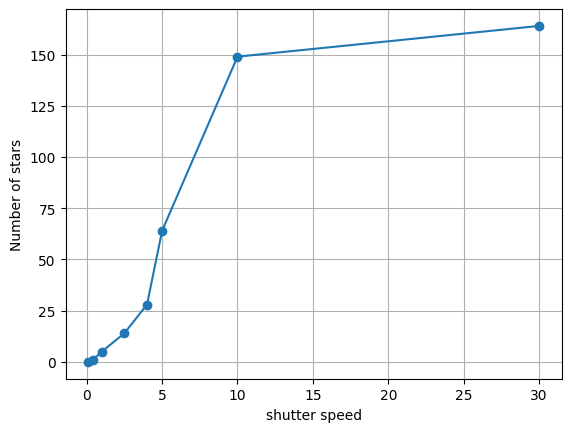

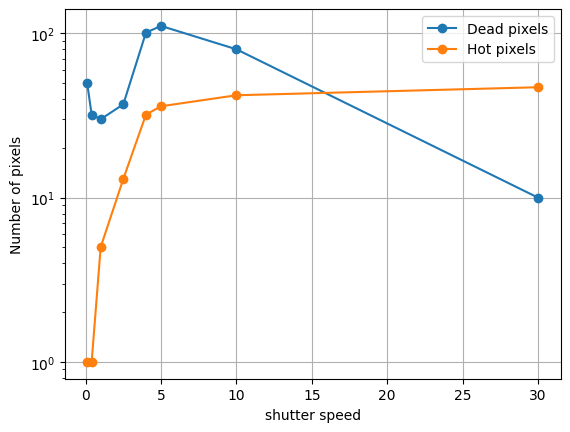

In [6]:
# Plot number of stars
plt.figure()
plt.plot(df_shutter["shutter"], df_shutter["n_stars"], "o-")
plt.xlabel("shutter speed")
plt.ylabel("Number of stars")
plt.grid()
plt.savefig(cl.Paths.saved / "shutter_n_stars.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot number of dead and hot pixels
plt.figure()
plt.plot(df_shutter["shutter"], df_shutter["n_dead"], "o-", label="Dead pixels")
plt.plot(df_shutter["shutter"], df_shutter["n_hot"], "o-", label="Hot pixels")
plt.xlabel("shutter speed")
plt.ylabel("Number of pixels")
plt.yscale("log")
plt.legend()
plt.grid()
plt.savefig(cl.Paths.saved / "shutter_defects.png", dpi=300, bbox_inches="tight")
plt.show()